In [47]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from utils import GradientBandit

In [48]:
class ConstantReward:
    def __init__(self,arms):
        reward = np.random.rand(arms)
        reward /= np.sum(reward)
        self.reward = reward

    def get_reward(self,context):
        return self.reward

In [49]:
class StrategicAgents:
    def __init__(self, private_types, dim, delta_radius, reward):
        self.private_types = private_types
        self.delta_radius = delta_radius
        self.t = 0
        self.reward = reward
        self.dim = dim

    def generate_context(self, policy):
        priv = self.private_types[self.t]
        reward = self.reward.get_reward(priv)
        bounds = [(-self.delta_radius, self.delta_radius)] * (self.dim)
        def objective(delta):
            if np.linalg.norm(delta) > self.delta_radius:
                return np.inf
            x_prime = np.append((priv+delta),[1])
            return -reward[np.argmax(policy@x_prime)]

        opt_delt = dual_annealing(objective, bounds)
        x_prime = priv + opt_delt.x
        self.t += 1
        return x_prime, reward[np.argmax(policy@np.append(x_prime,[1]))]


In [50]:
class ImperfectStrategicAgents:
    def __init__(self, private_types, dim, delta_radius, reward, policy_noise):
        self.private_types = private_types
        self.delta_radius = delta_radius
        self.t = 0
        self.reward = reward
        self.dim = dim
        self.policy_noise = policy_noise

    def generate_context(self, policy):
        imp_policy = policy + self.policy_noise*(np.random.random(policy.shape)-0.5)
        priv = self.private_types[self.t]
        reward = self.reward.get_reward(priv)
        bounds = [(-self.delta_radius, self.delta_radius)] * (self.dim)
        def objective(delta):
            if np.linalg.norm(delta) > self.delta_radius:
                return np.inf
            x_prime = np.append((priv+delta),[1])
            return -reward[np.argmax(imp_policy@x_prime)]

        opt_delt = dual_annealing(objective, bounds)
        x_prime = priv + opt_delt.x
        self.t += 1
        return x_prime, reward[np.argmax(policy@np.append(x_prime,[1]))]


In [51]:
class NonStrategicAgents:
    def __init__(self, private_types, dim, delta_radius, reward):
        self.private_types = private_types
        self.delta_radius = delta_radius
        self.t = 0
        self.reward = reward
        self.dim = dim

    def generate_context(self, policy):
        priv = self.private_types[self.t]
        reward = self.reward.get_reward(priv)

        self.t += 1
        return priv, reward[np.argmax(policy@np.append(priv,[1]))]


In [52]:
# T = 100
# ARMS = 4
# CONTEXT_DIM = 5
# delta_radius = 0.5

# private_types = np.random.rand(T,CONTEXT_DIM)
# rewards = ConstantReward(ARMS)
# strat_agents = StrategicAgents(private_types,CONTEXT_DIM,delta_radius,rewards)
# nostrat_agents = NonStrategicAgents(private_types,CONTEXT_DIM,delta_radius,rewards)

In [53]:
# policy = np.random.rand(CONTEXT_DIM,ARMS) - 0.5
# print("policy: {} ".format(policy))
# print("reward: {} ".format(rewards.get_reward(0)))

Sanity check to make sure the strategic agents are performing better than non-strategic agents

In [54]:
# total_strat_reward = 0
# total_nostrat_reward = 0
# for i in range(T):
#     xp, strat_reward = strat_agents.generate_context(policy)
#     x, nostrat_reward = nostrat_agents.generate_context(policy)
#     total_strat_reward += strat_reward
#     total_nostrat_reward += nostrat_reward

# print("strategic reward: {}, non-strategic reward: {}".format(total_strat_reward,total_nostrat_reward))

In [55]:
class ModelReward:
    def __init__(self,arms,dim,noise=0.01):
        self.theta = torch.rand(arms,dim)
        self.noise_scale = noise

    def get_reward(self,action,context):
        true_reward = action @ self.theta @ torch.t(context)
        return true_reward + (torch.rand(1)-0.5) * 2*self.noise_scale

In [56]:
class StrategyAwareGradientModel:
    def __init__(self,T,est_reward,lr,dim,delta_radius,arms,reward_func):
        self.delta_radius = delta_radius
        self.t = 0
        self.T = T
        self.est_agent_reward = est_reward
        self.dim = dim
        self.model = GradientBandit(arms,dim)
        self.reward_function = reward_func
        self.opt = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        self.criterion = torch.nn.L1Loss()

    def get_policy(self):
        return self.model.get_hyperplanes()

    def observe_reward(self, context):
        self.opt.zero_grad()
        context = torch.tensor(context).reshape(1,-1).float()
        est_agent_rew = torch.tensor(self.est_agent_reward.get_reward(context)).float()
        y_hat = self.model.forward(context,est_agent_rew)
        # print(y_hat)
        reward = self.reward_function.get_reward(y_hat,context)
        loss = self.criterion(1/reward,torch.zeros(1))
        loss.backward()
        self.opt.step()
        return reward

In [57]:
T = 500
ARMS = 4
CONTEXT_DIM = 5
DELTA = 0.1
lr = 0.05
model_reward_noise = 0.05
imperfect_agent_policy_noise = 0.05

private_types = np.random.rand(T,CONTEXT_DIM)
agent_rewards = ConstantReward(ARMS)
model_reward_func = ModelReward(ARMS,CONTEXT_DIM,model_reward_noise)
strat_agents = StrategicAgents(private_types,CONTEXT_DIM,DELTA,agent_rewards)
imperfect_agents = ImperfectStrategicAgents(private_types,CONTEXT_DIM,DELTA,agent_rewards,imperfect_agent_policy_noise)
nostrat_agents = NonStrategicAgents(private_types,CONTEXT_DIM,DELTA,agent_rewards)
model_strat = StrategyAwareGradientModel(T,agent_rewards,lr,CONTEXT_DIM,DELTA,ARMS,model_reward_func)
model_imp = StrategyAwareGradientModel(T,agent_rewards,lr,CONTEXT_DIM,DELTA,ARMS,model_reward_func)
model_ns = StrategyAwareGradientModel(T,agent_rewards,lr,CONTEXT_DIM,DELTA,ARMS,model_reward_func)

model_rewards_strat = []
model_rewards_imp = []
model_rewards_ns = []
agent_rewards_strat = []
agent_rewards_imp = []
agent_rewards_ns = []
for i in range(T):
    xstr, strat_reward = strat_agents.generate_context(model_strat.get_policy().detach().numpy())
    ximpf, impf_reward = imperfect_agents.generate_context(model_imp.get_policy().detach().numpy())
    xns, nostrat_reward = nostrat_agents.generate_context(model_ns.get_policy().detach().numpy())

    agent_rewards_strat += [strat_reward]
    agent_rewards_imp += [impf_reward]
    agent_rewards_ns += [nostrat_reward]

    model_rewards_strat += [model_strat.observe_reward(xstr)]
    model_rewards_imp   += [model_imp.observe_reward(ximpf)]
    model_rewards_ns    += [model_ns.observe_reward(xns)]
    

c:\Users\DeanA\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\DeanA\anaconda3\envs\pytorch\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


strat: 4.211253563642502 | impf: 4.243144251346588 | no strat: 4.220470118522644


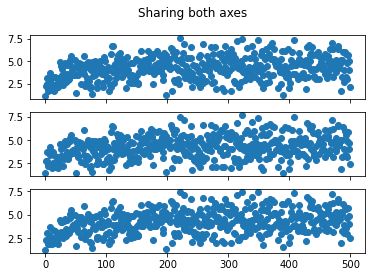

In [60]:
x = range(T)
fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Sharing both axes')
axs[0].scatter(x, [x.detach().numpy().item() for x in model_rewards_strat])
axs[1].scatter(x, [x.detach().numpy().item() for x in model_rewards_imp])
axs[2].scatter(x, [x.detach().numpy().item() for x in model_rewards_ns])
print("strat: {} | impf: {} | no strat: {}".format(sum([x.detach().numpy().item() for x in model_rewards_strat])/T, sum([x.detach().numpy().item() for x in model_rewards_imp])/T,sum([x.detach().numpy().item() for x in model_rewards_ns])/T,))

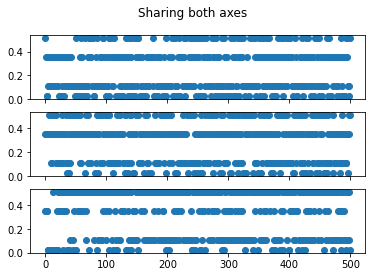

In [59]:
x = range(T)
fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Sharing both axes')
axs[0].scatter(x, [x.item() for x in agent_rewards_strat])
axs[1].scatter(x, [x.item() for x in agent_rewards_imp])
axs[2].scatter(x, [x.item() for x in agent_rewards_ns])